# CoSTA experimental notebook
The goal in this notebook is to reproduce results similar to Sindre Blakseths paper about CoSTA
## Contents:
- Imports and configs
- Data preparation
- Model training

## Imports and configs

In [10]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd

import FEM
import functions

In [11]:
### Configs for the notebook, changeable

# Modelling
p=1 # element polynomial order
sol=3 # solution index
Ne = 20 # number of elements (spacial)
T = 5 # Max time
time_steps = 2000 # Number of time steps
k = T/time_steps # time step length
alpha_train = [.1,.2,.3,.4,.5,.6,.9,1,1.2,1.3,1.4,1.6,1.7,1.8,1.9,2]
alpha_val = [.8,1.1]
alpha_test = [.7,1.5]
use_unknown_source = True

# NN architecture
hidden_layers = 4
hidden_layar_depth = 80
learning_rate = 1e-5
patience = 20
lrelu_slope = 0.01
neck_feats = 0
normalize = 1

# Other
extra_label = '' # string to add on csv file name to not avoid overwriting when experimenting



### Constants
tri = np.linspace(0,1,Ne+1)
csv_folder = '../preproject/csvs/'
zero_fnc = lambda x,t=1: x*0

## Data prep
Making the data sets takes some time, so if this is done already, skip and load below

In [14]:
### Make data sets

def data_set(alphas):
    '''This function makes data set for ham and pnn training/validation with alphas as given
    give alpha_train for training data etc.
    Data is not shuffled or normalized, nor split in input/output, that should be done later'''
    ham_data = np.zeros((len(alphas)*time_steps, Ne+1+neck_feats + Ne-1)) #Ne+1 for X, Ne-1 for Y
    pnn_data = np.zeros((len(alphas)*time_steps, Ne+1+neck_feats + Ne-1)) #Ne+1 for X, Ne-1 for Y
    for i, alpha in enumerate(alphas):
        f, u_ex = functions.sbmfact(T,alpha)[sol]
        if use_unknown_source:
            f = zero_fnc
        
        for t in range(time_steps):
            
            # we set the pnn_data as the exact temperature u_ex
            pnn_data[time_steps*i + t, :Ne+1] = u_ex(x=tri, t=t*k) # input: exact solution
            if neck_feats >=1:
                pnn_data[time_steps*i + t, Ne+1] = t*k
            if neck_feats >=2:
                pnn_data[time_steps*i + t, Ne+2] = alpha

            pnn_data[time_steps*i + t, Ne+1+neck_feats:] = u_ex(x=tri[1:-1], t=(t+1)*k) # outout: inner nodes, next step

            #'''
            # For the ham data it is more complicated.
            fem_model = FEM.Heat(tri,f,p,u_ex,k) # We start by definint a FEM heat model for the step
            fem_model.time = t*k # overwrite time to current time
            u_prev = u_ex(x=tri, t=t*k)
            fem_model.u_fem = u_prev # set fem_model_input (previus step) to exact values
            fem_model.step() # make a step with the model
            ham_data[time_steps*i + t, :Ne+1] = fem_model.u_fem
            b = fem_model.M@u_prev+fem_model.F*fem_model.k
            u_new_exact = u_ex(x=tri, t=(t+1)*k)
            sigma_corr = np.dot(fem_model.MA, u_new_exact) - b

            '''
            # Test the corrected source term
            fem_model = FEM.Heat(tri,f,p,u_ex,k) # We start by definint a FEM heat model for the step
            u_prev = u_ex(x=tri, t=t*k)
            fem_model.u_fem = u_prev # set fem_model_input (previus step) to exact values
            # Step:
            fem_model.time = (t+1)*k
            M,A,F = fem_model.discretize() # = __discretize(), now removed
            fem_model.F = F
            fem_model.M = M
            fem_model.MA = M+A*k
            fem_model.adb() # = __add_Dirichelt_bdry(), now removed
            u_fem = np.linalg.solve(fem_model.MA, M@u_prev+fem_model.F*k+sigma_corr) #Solve system

            assert (u_new_exact - u_fem) @ (u_new_exact - u_fem)**2 < 1e-10

            ham_data[time_steps*i + t, Ne+1:] = sigma_corr[1:-1] / fem_model.k
            
            '''
            # For the ham data it is more complicated.


            error = u_new_exact - fem_model.u_fem # error of fem prediction
            residual = fem_model.MA @ error
            ham_data[time_steps*i + t, Ne+1:] = residual[1:-1] # set output to residual

            assert (sigma_corr[1:-1] - residual[1:-1]) @ (sigma_corr[1:-1] - residual[1:-1]) < 1e-14 # the two ways of getting output is equivalent
            #'''
    return ham_data, pnn_data

ham_train_data, pnn_train_data = data_set(alpha_test)
ham_val_data, pnn_val_data = data_set(alpha_val)

df_ham_train = pd.DataFrame(ham_train_data, columns=[*[f'i{x}' for x in tri],*[f'nf{i}' for i in np.arange(neck_feats)], *[f'o{x}' for x in tri[1:-1]]])
df_pnn_train = pd.DataFrame(pnn_train_data, columns=[*[f'i{x}' for x in tri],*[f'nf{i}' for i in np.arange(neck_feats)], *[f'o{x}' for x in tri[1:-1]]])
df_ham_val = pd.DataFrame(ham_val_data, columns=[*[f'i{x}' for x in tri],*[f'nf{i}' for i in np.arange(neck_feats)], *[f'o{x}' for x in tri[1:-1]]])
df_pnn_val = pd.DataFrame(pnn_val_data, columns=[*[f'i{x}' for x in tri],*[f'nf{i}' for i in np.arange(neck_feats)], *[f'o{x}' for x in tri[1:-1]]])

#df_ham_train.to_csv(csv_folder+f'ham_train_N{Ne}_ts{time_steps}'+extra_label+'.csv', index = False)
#df_pnn_train.to_csv(csv_folder+f'ham_train_N{Ne}_ts{time_steps}'+extra_label+'.csv', index = False)


In [4]:
### Load data sets
#df_ham_train = pd.read_csv(csv_folder+f'ham_train_N{Ne}_ts{time_steps}'+extra_label+'.csv')
#df_pnn_train = pd.read_csv(csv_folder+f'ham_train_N{Ne}_ts{time_steps}'+extra_label+'.csv')

### make data sets ready:

# As long as val and train is the same alphas, we use the same data
#if alpha_val == alpha_train:
#    df_ham_val = df_ham_train.copy()
#    df_pnn_val = df_pnn_train.copy()

# Shuffle
df_ham_train = df_ham_train.sample(frac=1)
df_pnn_train = df_pnn_train.sample(frac=1)
df_ham_val = df_ham_val.sample(frac=1)
df_pnn_val = df_pnn_val.sample(frac=1)

# Get numpy arrays
ham_train = df_ham_train.values
pnn_train = df_pnn_train.values
ham_val = df_ham_val.values
pnn_val = df_pnn_val.values

# Split intp input (X) and output (Y)
ham_train_X = ham_train[:, :Ne+1+neck_feats]
ham_train_Y = ham_train[:, Ne+1+neck_feats:]
ham_val_X = ham_val[:, :Ne+1+neck_feats]
ham_val_Y = ham_val[:, Ne+1+neck_feats:]
pnn_train_X = pnn_train[:, :Ne+1+neck_feats]
pnn_train_Y = pnn_train[:, Ne+1+neck_feats:]
pnn_val_X = pnn_val[:, :Ne+1+neck_feats]
pnn_val_Y = pnn_val[:, Ne+1+neck_feats:]

'''
# Normalize, for each input
if normalize:
    ham_mean= ham_train_X.mean(0)
    ham_var = ham_train_X.var(0)
    pnn_mean= pnn_train_X.mean(0)
    pnn_var = pnn_train_X.var(0)
    print(ham_var)
    print(pnn_var)
    epsilon = 0.01
    for i in range(Ne+1):
        ham_train_X[:,i] = (ham_train_X[:,i]-ham_mean[i]) / (ham_var[i]+epsilon)**0.5
        ham_val_X[:,i] = (ham_val_X[:,i]-ham_mean[i]) / (ham_var[i]+epsilon)**0.5
        pnn_train_X[:,i] = (pnn_train_X[:,i]-pnn_mean[i]) / (pnn_var[i]+epsilon)**0.5
        pnn_val_X[:,i] = (pnn_val_X[:,i]-pnn_mean[i]) / (pnn_var[i]+epsilon)**0.5
'''
if normalize:
    ham_mean= ham_train_X.mean()
    ham_var = ham_train_X.var()
    pnn_mean= pnn_train_X.mean()
    pnn_var = pnn_train_X.var()
    print(ham_mean)
    print(pnn_mean)
    print(ham_var)
    print(pnn_var)
    epsilon = 0.01
    ham_train_X = (ham_train_X-ham_mean) / (ham_var+epsilon)**0.5
    ham_val_X = (ham_val_X-ham_mean) / (ham_var+epsilon)**0.5
    pnn_train_X = (pnn_train_X-pnn_mean) / (pnn_var+epsilon)**0.5
    pnn_val_X = (pnn_val_X-pnn_mean) / (pnn_var+epsilon)**0.5

1.8991965196414773
1.896281180335021
0.016155404888710985
0.017191314909907905


## Model initialisation and training

In [5]:
def get_model():

    if neck_feats == 0:
        inputs = tf.keras.Input(shape=(Ne+1))
        x = inputs
        x = tf.keras.layers.LeakyReLU(alpha=lrelu_slope)(x)
        for h in range(hidden_layers):
            x = tf.keras.layers.Dense(hidden_layar_depth)(x)
            x = tf.keras.layers.LeakyReLU(alpha=lrelu_slope)(x)
        x = tf.keras.layers.Dense(Ne-1)(x)
        model = tf.keras.Model(inputs,x)
        model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate))

    if neck_feats > 0:
        inputs = tf.keras.Input(shape=(Ne+1))
        x = inputs
        for depth in [20,20,12,8]:
            x = tf.keras.layers.Dense(depth)(x)
            x = tf.keras.layers.LeakyReLU(alpha=lrelu_slope)(x)
        model = tf.keras.Model(inputs,x)

        inputs = tf.keras.Input(shape=(neck_feats))
        x = inputs
        neck_input_model = tf.keras.Model(inputs,x)

        combined_input = tf.keras.layers.concatenate([model.output, neck_input_model.output])
        x = tf.keras.layers.Dense(7)(combined_input)
        x = tf.keras.layers.Dense(13)(combined_input)
        x = tf.keras.layers.Dense(Ne-1)(x)

        model = tf.keras.Model(inputs = [model.input, neck_input_model.input], outputs = x)
        model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(learning_rate=10*learning_rate))
    return model

hamNN = get_model()
pureNN = get_model()

2021-10-24 12:17:09.490673: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-24 12:17:09.490713: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-24 12:17:09.490743: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vivus): /proc/driver/nvidia/version does not exist
2021-10-24 12:17:09.491159: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2021-10-24 12:17:09.707769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


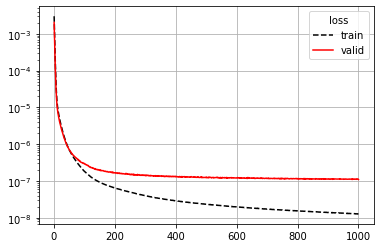

In [6]:
if neck_feats == 0:
    ham_hist = hamNN.fit(x=ham_train_X, y=ham_train_Y, epochs=1000, verbose=0, batch_size = 32,  validation_data=(ham_val_X, ham_val_Y))#, epochs=500)
    #pnn_hist = pureNN.fit(x=pnn_train_X, y=pnn_train_Y, epochs=200, verbose=0, batch_size = 32,  validation_data=(pnn_val_X, pnn_val_Y))#, epochs=500)
else:
    pnn_hist = pureNN.fit(x=[pnn_train_X[:,:Ne+1], pnn_train_X[:,Ne+1:]], y=pnn_train_Y, epochs=200, verbose=0, batch_size = 32,  validation_data=([pnn_val_X[:,:Ne+1], pnn_val_X[:,Ne+1:]], pnn_val_Y))#, epochs=500)

if 0: #ignore pnn for now
    epochs_vector = np.arange(1, len(pnn_hist.history['loss'])+1)
    plt.plot(epochs_vector, pnn_hist.history['loss'], 'k--', label='train')
    plt.plot(epochs_vector, pnn_hist.history['val_loss'], 'r', label='valid')
    plt.yscale('log')
    plt.grid()
    plt.legend(title='loss')
    plt.show()

epochs_vector = np.arange(1, len(ham_hist.history['loss'])+1)
plt.plot(epochs_vector, ham_hist.history['loss'], 'k--', label='train')
plt.plot(epochs_vector, ham_hist.history['val_loss'], 'r', label='valid')
plt.yscale('log')
plt.grid()
plt.legend(title='loss')
plt.show()

## Testing

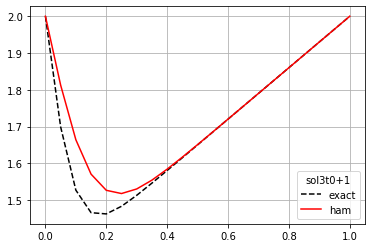

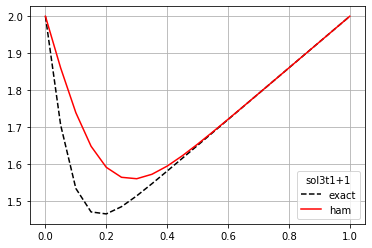

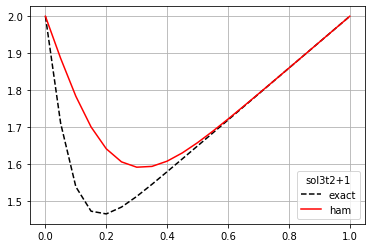

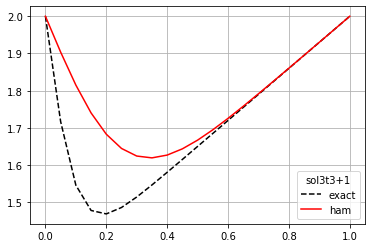

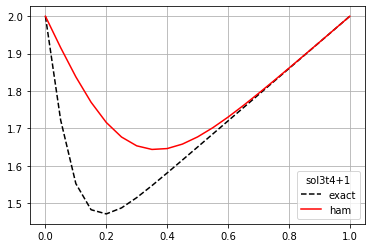

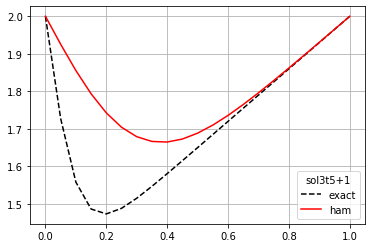

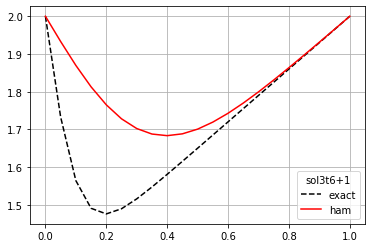

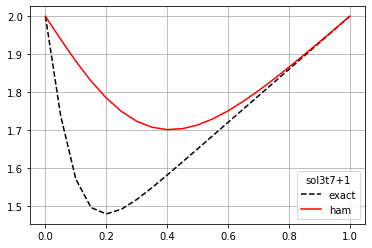

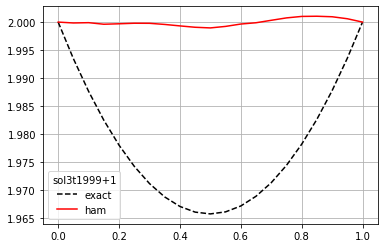

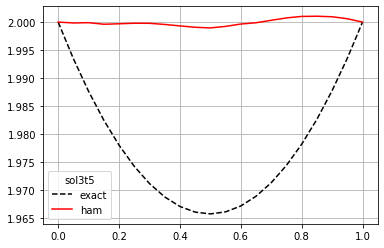

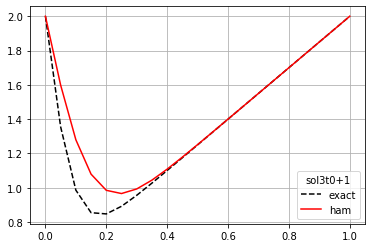

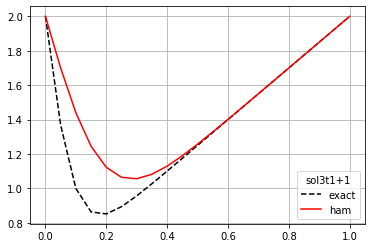

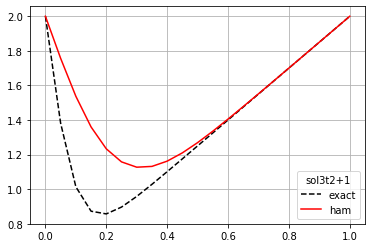

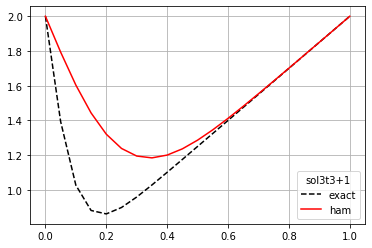

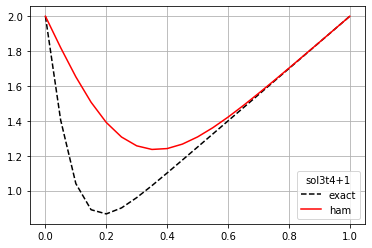

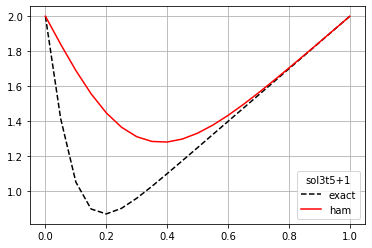

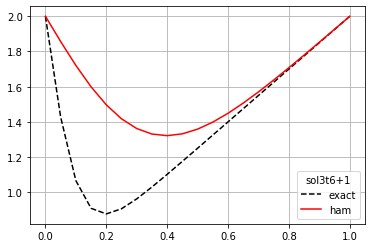

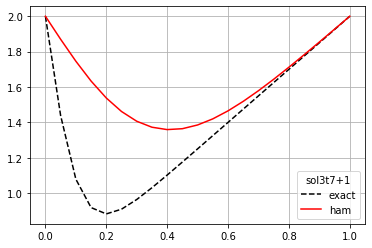

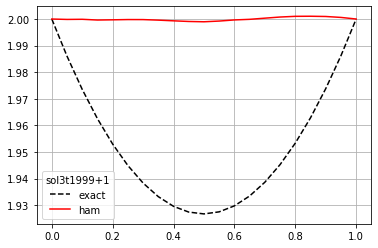

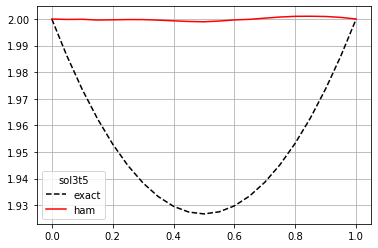

In [7]:
# HAM
for alpha in alpha_test:
    f, u_ex = functions.sbmfact(T,alpha)[sol]
    if use_unknown_source:
        f = zero_fnc

    u = u_ex(x=tri, t=0)

    fem_model = FEM.Heat(tri,f,1,u_ex,k)

    for t in range(time_steps):
        u_prev = u # set u_prev (used as fem_model input) as the previous step
        fem_model.time = t*k
        fem_model.u_fem = u_prev
        fem_model.step()
        #u = u_ex(t=(t+1)*k, x = tri) # set the next u (only boundary is kept, the rest is overwritten)
        u_fem = fem_model.u_fem
        u_fem = np.array([u_fem]) # this format is needed for NN

        if normalize:
            u_fem = (u_fem - ham_mean) / (ham_var+epsilon)**0.5
        if neck_feats == 0:
            correction = np.zeros(Ne+1)
            correction[1:-1] = hamNN(u_fem)
            fem_model.step(correction=correction*k)
            u = fem_model.u_fem
        else:
            assert 0 # not implemented

        if t<8:
            plt.plot(tri,u_ex(t=(t+1)*k,x=tri), 'k--', label='exact')
            plt.plot(tri,u, 'r', label='ham')
            plt.grid()
            plt.legend(title=f'sol{sol}t{t}+1')
            plt.show()

    plt.plot(tri,u_ex(t=(t+1)*k,x=tri), 'k--', label='exact')
    plt.plot(tri,u, 'r', label='ham')
    plt.grid()
    plt.legend(title=f'sol{sol}t{t}+1')
    plt.show()

    plt.plot(tri,u_ex(t=T,x=tri), 'k--', label='exact')
    plt.plot(tri,u, 'r', label='ham')
    plt.grid()
    plt.legend(title=f'sol{sol}t{T}')
    plt.show()



# start by testing pnn:
if 0:
    for alpha in alpha_test:
        f, u_ex = functions.sbmfact(T,alpha)[sol]
        if use_unknown_source:
            f = zero_fnc

        u = u_ex(x=tri, t=0)


        for t in range(time_steps):
            u_prev = u # set u_prev (used as model input) as the previous step
            u_prev = np.array([u_prev]) # this format is needed for NN
            u = u_ex(t=(t+1)*k, x = tri) # set the next u (only boundary is kept, the rest is overwritten)
            
            if normalize:
                for i in range(Ne+1):
                    u_prev[0,i] = (u_prev[0,i] - pnn_mean[i]) / (pnn_var[i]+epsilon)**0.5
            if neck_feats == 0:
                u[1:-1] = pureNN(u_prev)
            elif neck_feats == 1:
                u[1:-1] = pureNN( [u_prev, [np.array([(t*k-pnn_mean[i+1])/(pnn_var[i+1]+epsilon)**0.5] if normalize else [t*k])]])
            elif neck_feats == 2:
                u[1:-1] = pureNN( [u_prev, [
                    np.array(
                        [[(t*k-pnn_mean[i+1])/(pnn_var[i+1]+epsilon)**0.5, (alpha-pnn_mean[i+2])/(pnn_var[i+2]+epsilon)**0.5] if normalize else[t*k, alpha]]
                        )
                    ]])


    plt.plot(tri,u_ex(t=T,x=tri), 'k--', label='exact')
    plt.plot(tri,u, 'r', label='pnn')
    plt.grid()
    plt.legend(title=f'sol{sol}')
    plt.show()


In [8]:
u_prev

array([2.        , 1.99984414, 1.99989631, 1.99961703, 1.999698  ,
       1.9997953 , 1.99978354, 1.99958068, 1.99932017, 1.99907728,
       1.99896118, 1.99923165, 1.9996528 , 1.9998823 , 2.00031896,
       2.00074687, 2.00101108, 2.0010425 , 2.00095259, 2.00059793,
       2.        ])

In [9]:

pnn_mean


1.896281180335021